In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from datetime import datetime

# Forecasting Climate
https://www.kaggle.com/code/leandrovrabelo/climate-change-forecast-sarima-model/notebook

In [2]:
def check_stationarity(y, lags_plots=48, figsize=(22,8), title='Trend'):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title(title)
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    # print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    # print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe series seems to be stationary')
    else:
        print("\nWarning: The Test Statistics is higher than the Critical Value of 5%.\nThe series isn't stationary")
    plt.show()
    

In [3]:
aus_df = pd.read_csv('./data/processed/Austria.csv')
aus_df['Date'] = pd.to_datetime(aus_df['Date'])
aus_df = aus_df.set_index('Date')

In [5]:
train_temp, test_temp = aus_df[aus_df.index < '2020-01-01']['Temperature'].dropna(), aus_df[aus_df.index >= '2020-01-01']['Temperature'].dropna()

/tmp/ipykernel_29945/788673729.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The Test Statistics is lower than the Critical Value of 5%.
The series seems to be stationary


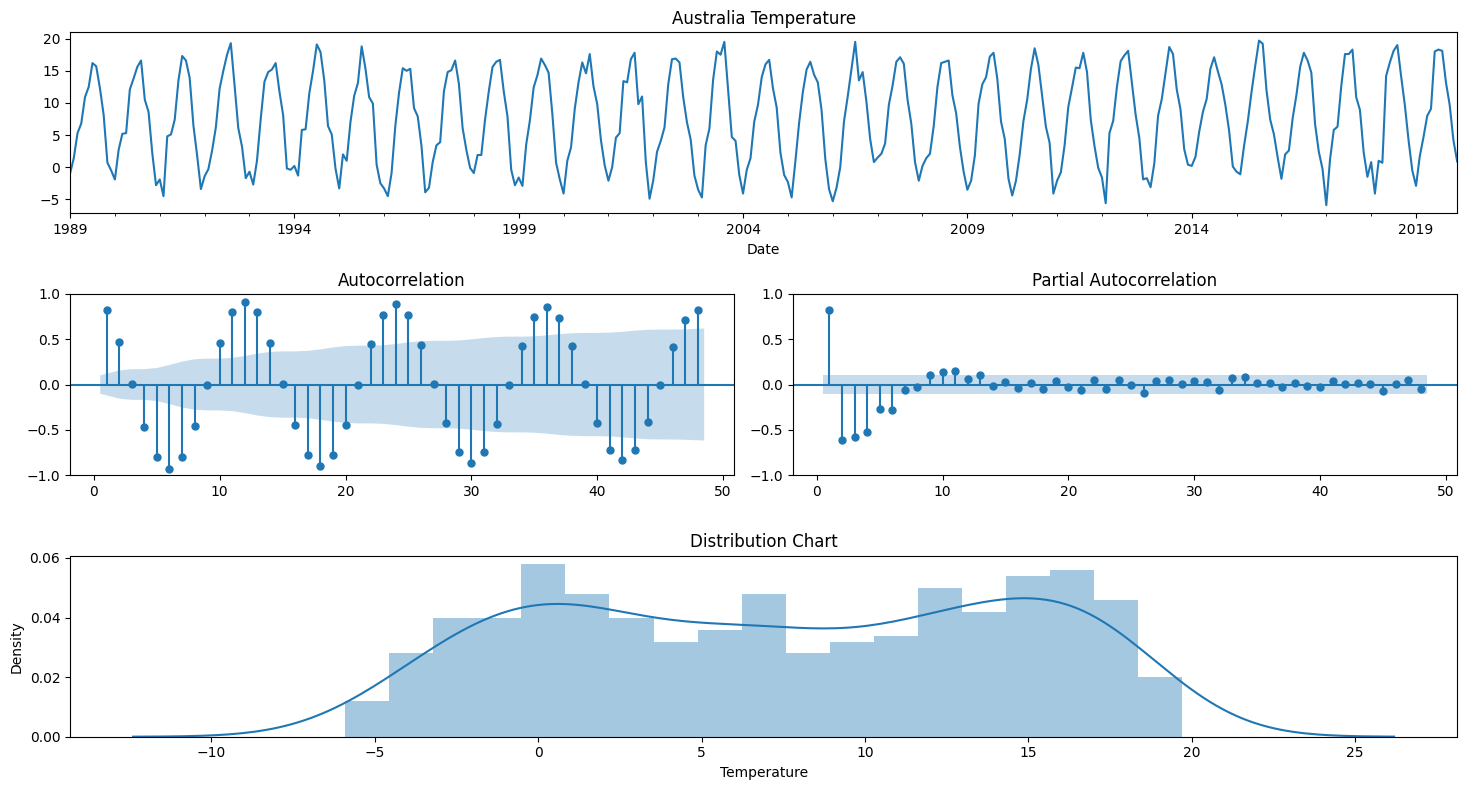

/tmp/ipykernel_29945/788673729.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The Test Statistics is lower than the Critical Value of 5%.
The series seems to be stationary


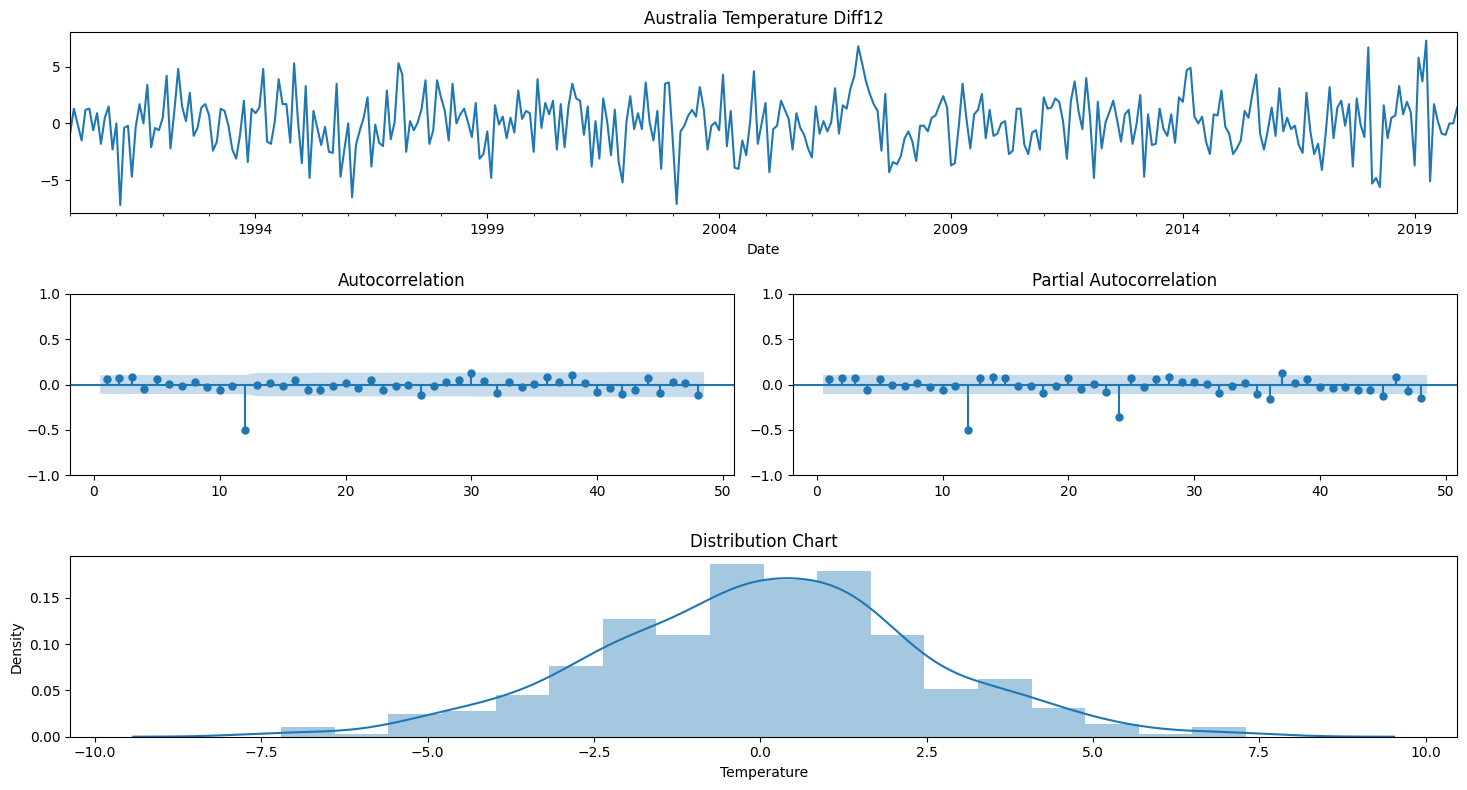

In [6]:
# find parameter analytically
check_stationarity(train_temp, title='Australia Temperature')
check_stationarity(train_temp.diff(12).dropna(), title='Australia Temperature Diff12')

In [7]:
train_prec, test_prec = aus_df[aus_df.index < '2020-01-01']['Precipitation'].dropna(), aus_df[aus_df.index >= '2020-01-01']['Precipitation'].dropna()

/tmp/ipykernel_29945/788673729.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The Test Statistics is lower than the Critical Value of 5%.
The series seems to be stationary


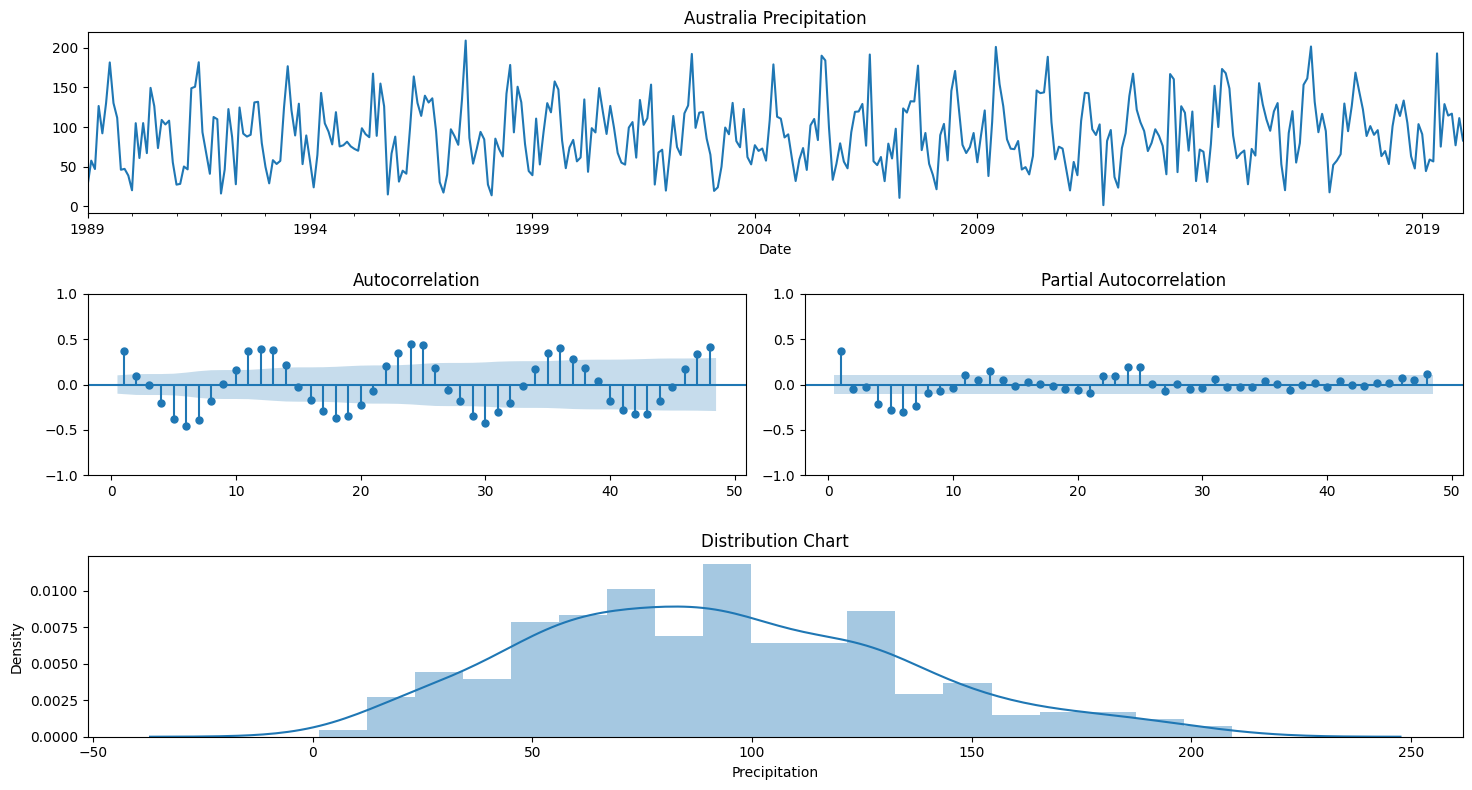

/tmp/ipykernel_29945/788673729.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The Test Statistics is lower than the Critical Value of 5%.
The series seems to be stationary


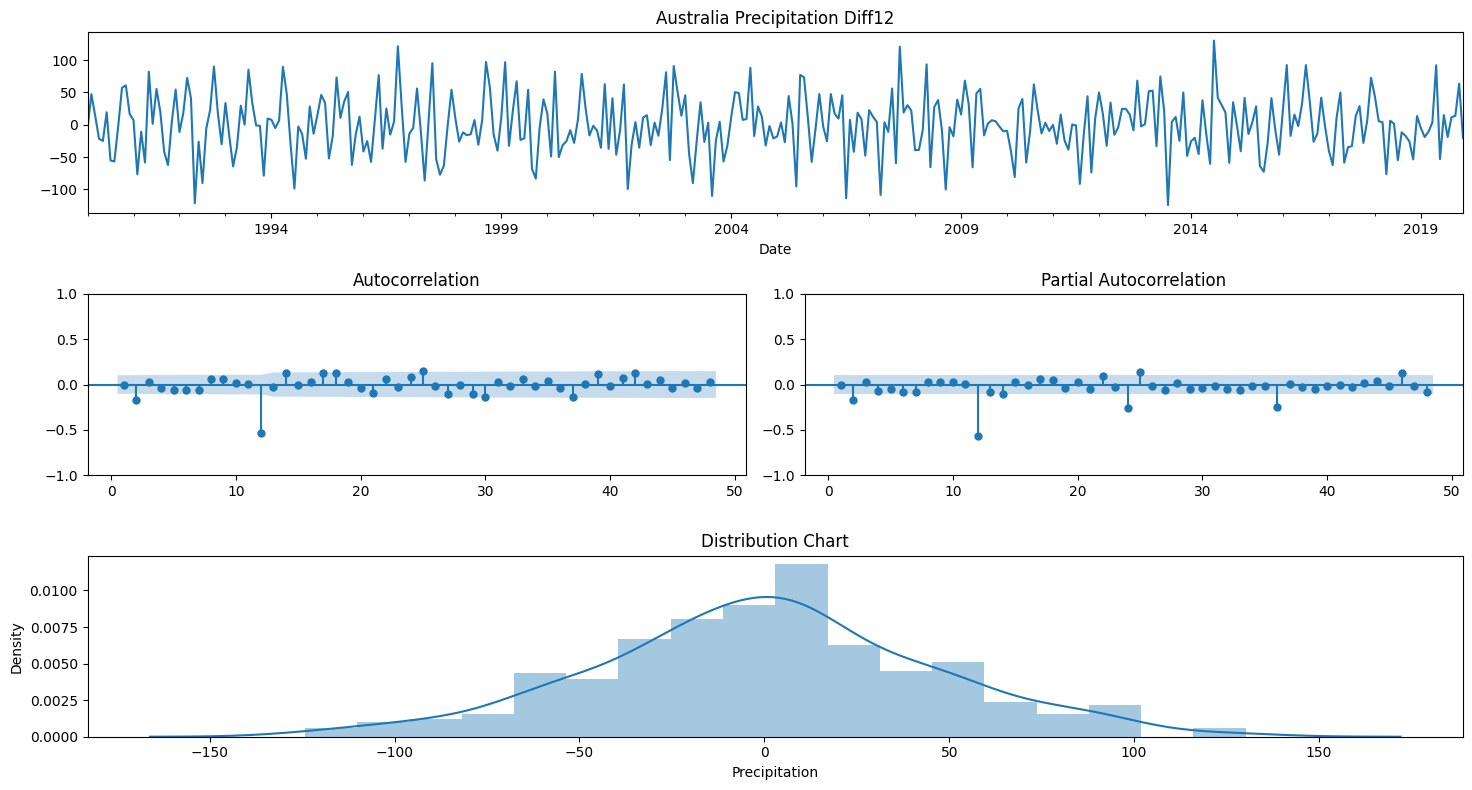

In [8]:
# find parameter analytically
check_stationarity(train_prec, title='Australia Precipitation')
check_stationarity(train_prec.diff(12).dropna(), title='Australia Precipitation Diff12')

In [9]:
# find parameter brute force
def grid_search_sarimax(ori_train, ori_test):
    train, test = ori_train.copy(), ori_test.copy()

    best_params = None
    const_prediction = np.resize(train[-12:].values, len(test))
    best_rmse = sqrt(mean_squared_error(test, const_prediction))
    best_r2 = r2_score(test, const_prediction)
    
    adfinput = adfuller(ori_train)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    if adftest[0].round(2) < adftest[5].round(2): #stationary
        q = 0
    else:
        q = 1
        
    for p in range(1, 4):
        for r in range(0, 2):
            for P in range(0, 2):
                for Q in range(0, 2):
                    for R in range(0, 2):
                        for trend in ['n', 'c']:
                            with warnings.catch_warnings():
                                try:
                                    warnings.simplefilter("ignore")
                                    model = sm.tsa.statespace.SARIMAX(train, order=(p,q,r), seasonal_order=(P,Q,R,12), trend=trend)
                                    result = model.fit(disp=False)
                                    prediction = result.predict(start=(len(train)), end=(len(train)+len(test)-1))
                                except np.linalg.linalg.LinAlgError:
                                    # print('error with parameter', [(p,q,r), (P,Q,R,12), trend])
                                    continue
                            # check mle convergence
                            if not result.mle_retvals['converged']:
                                continue
                            rmse = sqrt(mean_squared_error(test, prediction))
                            r2 = r2_score(test, prediction)
                            if rmse < best_rmse and r2 > best_r2:
                                best_params = [(p,q,r), (P,Q,R,12), trend]
                                best_rmse = rmse
                                best_r2 = r2
    return best_params, best_rmse, best_r2

In [10]:
const_prediction = np.resize(train_temp[-12:].values, len(test_temp))
print(sqrt(mean_squared_error(test_temp, const_prediction)))
print(r2_score(test_temp, const_prediction))

1.6606558276108199
0.9394919059115119


In [11]:
grid_search_sarimax(train_temp, test_temp)

([(2, 0, 1), (0, 1, 1, 12), 'c'], 1.3884922427414637, 0.9576999265629231)

In [13]:
model = sm.tsa.statespace.SARIMAX(train_temp, order=(2,0,1), seasonal_order=(0,1,1,12), trend='c')
result = model.fit(disp=False)

/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [14]:
prediction = result.predict(start=(len(train_temp)), end=(len(train_temp)+len(test_temp)-1))

RMSE: 1.3884922427414637
R2 0.9576999265629231


<Axes: >

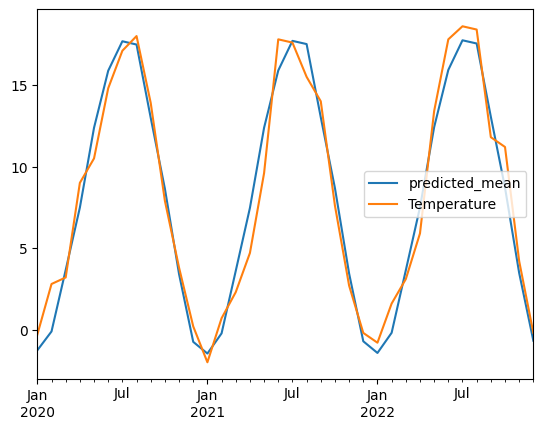

In [15]:
print('RMSE:', sqrt(mean_squared_error(test_temp, prediction)))
print('R2', r2_score(test_temp, prediction))
pd.concat([prediction, test_temp], axis=1).plot()

In [26]:
# process all country
imputed_dir = './data/imputed'
processed_dir = './data/processed'
os.makedirs(imputed_dir, exist_ok=True)

for f in os.listdir(processed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        country_df = pd.read_csv(os.path.join(processed_dir, f))
        country_df['Date'] = pd.to_datetime(country_df['Date'])
        country_df = country_df.set_index('Date')
        for feature in ['Temperature', 'Precipitation']:
            train, test = country_df[country_df.index < '2020-01-01'][feature].dropna(), country_df[country_df.index >= '2020-01-01'][feature].dropna()
            best_param, best_rmse, best_r2 = grid_search_sarimax(train, test)
            print(f'{f}|{feature} - Params: {best_param} RMSE: {best_rmse:.3f} R2: {best_r2: .4f}')
            
            train, test = country_df[country_df.index <= country_df[feature].last_valid_index()][feature], country_df[country_df.index > country_df[feature].last_valid_index()][feature]

            model = sm.tsa.statespace.SARIMAX(train, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
            result = model.fit(disp=False)
            # while not result.mle_retvals['converged']: #somehow austria not converging has weird behaviour
            #     print('warning not converged when performing full train, reducing order to 0')
            #     if best_param[0][1] > 0:
            #         best_param[0] = (best_param[0][0], 0, best_param[0][2])
            #     elif best_param[1][1] > 0:
            #         best_param[1] = (best_param[1][0], 0, best_param[1][2], best_param[1][3])
            #     else:
            #         break
            #     model = sm.tsa.statespace.SARIMAX(train, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
            #     result = model.fit(disp=False)
            prediction = result.predict(start=(len(train)), end=(len(train)+len(test)-1))
            country_df.loc[prediction.index, feature] = prediction
        # break
        country_df.reset_index(names='Date').to_csv(os.path.join(imputed_dir, f), index=False)

processing Japan.csv
Japan.csv|Temperature - Params: [(3, 0, 0), (1, 1, 1, 12), 'c'] RMSE: 0.921 R2:  0.9869


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Japan.csv|Precipitation - Params: [(3, 0, 0), (1, 1, 0, 12), 'n'] RMSE: 49.907 R2:  0.5944


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Korea (ROK).csv
Korea (ROK).csv|Temperature - Params: [(3, 0, 0), (0, 1, 1, 12), 'c'] RMSE: 1.209 R2:  0.9812


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Korea (ROK).csv|Precipitation - Params: [(3, 0, 1), (0, 1, 1, 12), 'n'] RMSE: 50.096 R2:  0.7910


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Chile.csv
Chile.csv|Temperature - Params: [(3, 0, 1), (1, 1, 0, 12), 'c'] RMSE: 0.633 R2:  0.9594


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Chile.csv|Precipitation - Params: [(1, 0, 1), (1, 1, 1, 12), 'c'] RMSE: 17.807 R2:  0.4956


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


processing Maldives.csv
Maldives.csv|Temperature - Params: [(2, 0, 1), (0, 1, 1, 12), 'n'] RMSE: 0.238 R2:  0.7135


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Maldives.csv|Precipitation - Params: [(2, 0, 1), (1, 0, 1, 12), 'n'] RMSE: 37.796 R2:  0.6889


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Cambodia.csv
Cambodia.csv|Temperature - Params: [(3, 0, 1), (1, 1, 1, 12), 'n'] RMSE: 0.622 R2:  0.7595


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cambodia.csv|Precipitation - Params: [(2, 0, 1), (1, 1, 1, 12), 'c'] RMSE: 56.253 R2:  0.8293


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


processing Singapore.csv
Singapore.csv|Temperature - Params: [(3, 0, 1), (1, 1, 1, 12), 'n'] RMSE: 0.275 R2:  0.7754


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Singapore.csv|Precipitation - Params: [(2, 0, 0), (1, 1, 1, 12), 'c'] RMSE: 92.497 R2:  0.2526


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing USA.csv
USA.csv|Temperature - Params: [(3, 1, 0), (1, 0, 1, 12), 'n'] RMSE: 0.885 R2:  0.9898


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


USA.csv|Precipitation - Params: [(3, 0, 0), (1, 0, 1, 12), 'n'] RMSE: 8.789 R2:  0.2964


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Chinese Taipei.csv
Chinese Taipei.csv|Temperature - Params: [(3, 0, 1), (1, 1, 0, 12), 'c'] RMSE: 1.329 R2:  0.8922


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Chinese Taipei.csv|Precipitation - Params: [(1, 0, 0), (1, 0, 0, 12), 'n'] RMSE: 113.975 R2: -0.1229
processing Thailand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Thailand.csv|Temperature - Params: [(3, 0, 1), (1, 1, 1, 12), 'n'] RMSE: 0.599 R2:  0.8675


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Thailand.csv|Precipitation - Params: [(1, 0, 1), (0, 1, 1, 12), 'c'] RMSE: 41.425 R2:  0.8379


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


processing Indonesia.csv
Indonesia.csv|Temperature - Params: [(2, 1, 1), (1, 0, 0, 12), 'n'] RMSE: 0.204 R2:  0.4790


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Indonesia.csv|Precipitation - Params: [(1, 0, 0), (0, 1, 1, 12), 'c'] RMSE: 33.977 R2:  0.1768


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Turkey.csv
Turkey.csv|Temperature - Params: [(1, 0, 1), (0, 1, 1, 12), 'c'] RMSE: 1.307 R2:  0.9715


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Turkey.csv|Precipitation - Params: [(2, 0, 0), (1, 0, 1, 12), 'n'] RMSE: 16.720 R2:  0.5472


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Macao, China.csv
Macao, China.csv|Temperature - Params: [(3, 0, 1), (1, 1, 0, 12), 'n'] RMSE: 1.240 R2:  0.9362


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Macao, China.csv|Precipitation - Params: [(1, 0, 0), (1, 0, 1, 12), 'n'] RMSE: 104.253 R2:  0.5694


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


processing Australia.csv
Australia.csv|Temperature - Params: [(1, 0, 1), (1, 1, 1, 12), 'n'] RMSE: 0.689 R2:  0.9778


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Australia.csv|Precipitation - Params: [(1, 0, 0), (0, 1, 1, 12), 'n'] RMSE: 8.265 R2:  0.9012


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing New Zealand.csv
New Zealand.csv|Temperature - Params: [(1, 1, 1), (1, 1, 1, 12), 'c'] RMSE: 0.682 R2:  0.9591


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


New Zealand.csv|Precipitation - Params: [(1, 0, 1), (0, 1, 1, 12), 'n'] RMSE: 32.964 R2:  0.1053


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Czech.csv
Czech.csv|Temperature - Params: [(1, 0, 1), (0, 1, 1, 12), 'c'] RMSE: 1.510 R2:  0.9525


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Czech.csv|Precipitation - Params: [(3, 0, 0), (1, 0, 1, 12), 'n'] RMSE: 22.843 R2:  0.4472


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


processing Hawaii.csv
Hawaii.csv|Temperature - Params: [(3, 1, 1), (1, 0, 1, 12), 'c'] RMSE: 0.422 R2:  0.9037


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Hawaii.csv|Precipitation - Params: [(3, 0, 1), (0, 1, 1, 12), 'n'] RMSE: 98.258 R2:  0.2576


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Mexico.csv
Mexico.csv|Temperature - Params: [(1, 0, 1), (1, 1, 1, 12), 'c'] RMSE: 0.584 R2:  0.9743


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mexico.csv|Precipitation - Params: [(2, 0, 0), (1, 0, 1, 12), 'n'] RMSE: 14.409 R2:  0.9243


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Hong Kong SAR.csv
Hong Kong SAR.csv|Temperature - Params: [(3, 0, 0), (1, 1, 0, 12), 'n'] RMSE: 1.278 R2:  0.9250


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Hong Kong SAR.csv|Precipitation - Params: [(2, 0, 1), (1, 0, 1, 12), 'n'] RMSE: 115.985 R2:  0.5595


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Canada.csv
Canada.csv|Temperature - Params: [(3, 0, 1), (1, 0, 1, 12), 'n'] RMSE: 0.932 R2:  0.9943


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Canada.csv|Precipitation - Params: [(3, 0, 0), (1, 0, 1, 12), 'n'] RMSE: 2.436 R2:  0.9551


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Austria.csv
Austria.csv|Temperature - Params: [(2, 0, 1), (0, 1, 1, 12), 'c'] RMSE: 1.388 R2:  0.9577


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Austria.csv|Precipitation - Params: [(3, 0, 0), (1, 1, 1, 12), 'n'] RMSE: 32.843 R2:  0.5565


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


indo_df = pd.read_csv(os.path.join(imputed_dir, 'Indonesia.csv'))

indo_df

np.resize(indo_df.iloc[108:120]['Precipitation'].values, 19)

indo_df.loc[120:, 'Precipitation'] = np.resize(indo_df.iloc[108:120]['Precipitation'].values, 19)

indo_df['Precipitation'].plot()
plt.axvline(120, color='black')

indo_df.to_csv(os.path.join(imputed_dir, 'Indonesia.csv'), index=False)

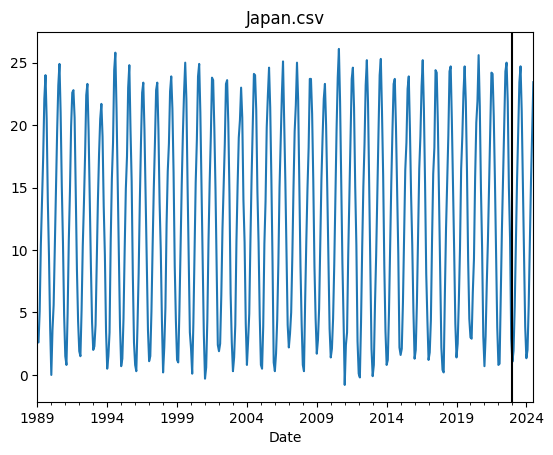

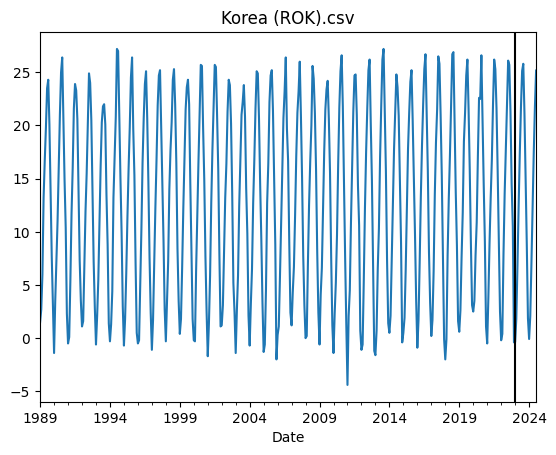

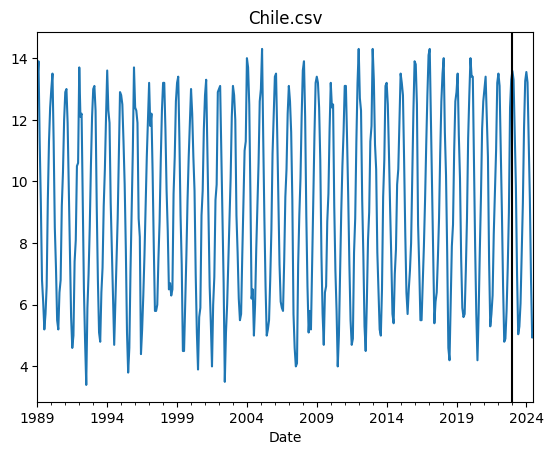

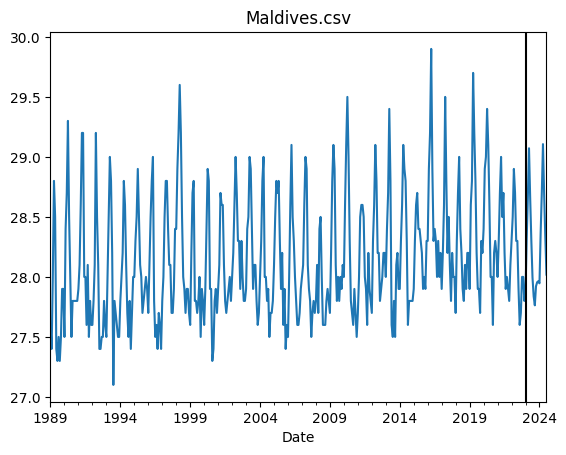

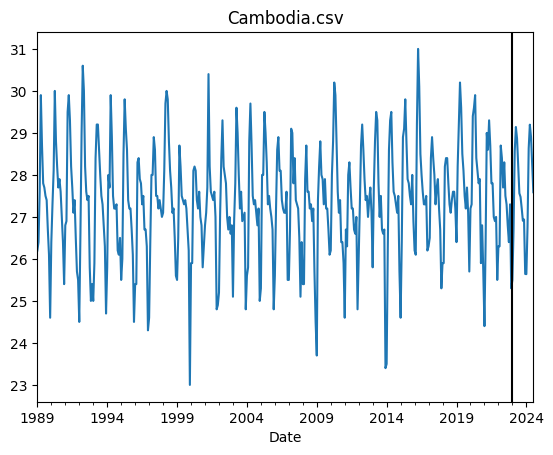

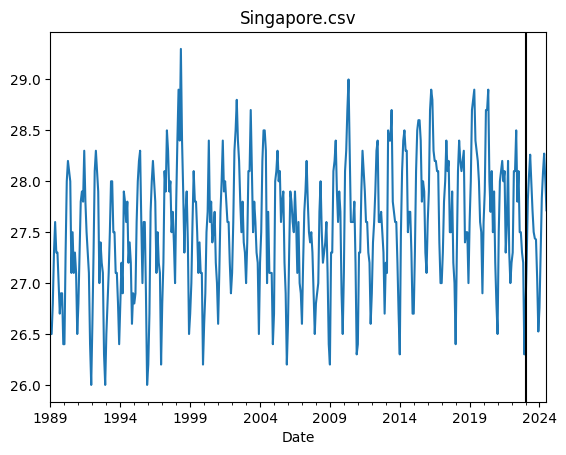

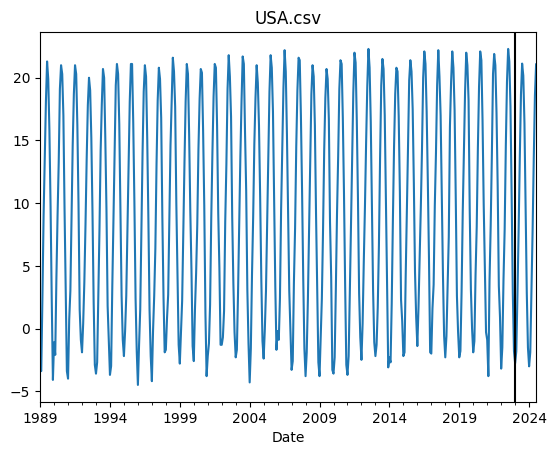

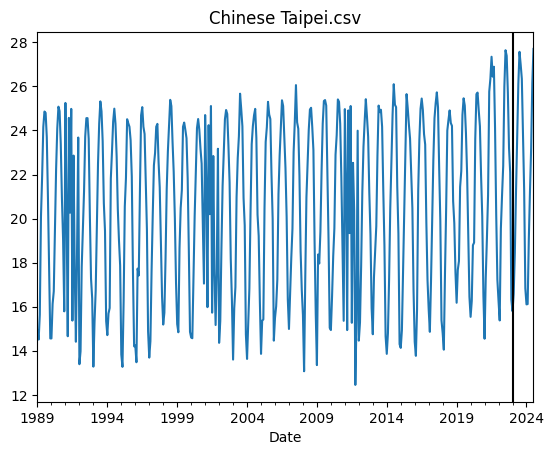

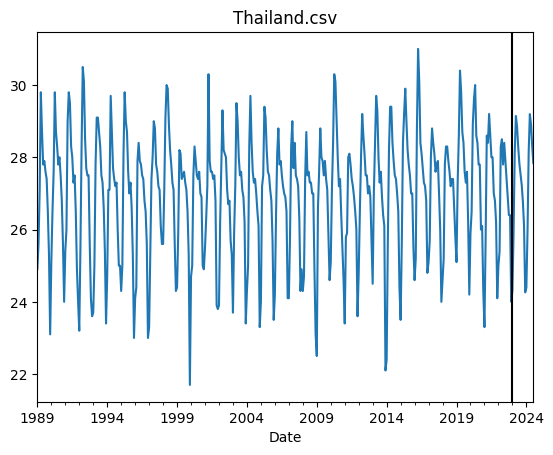

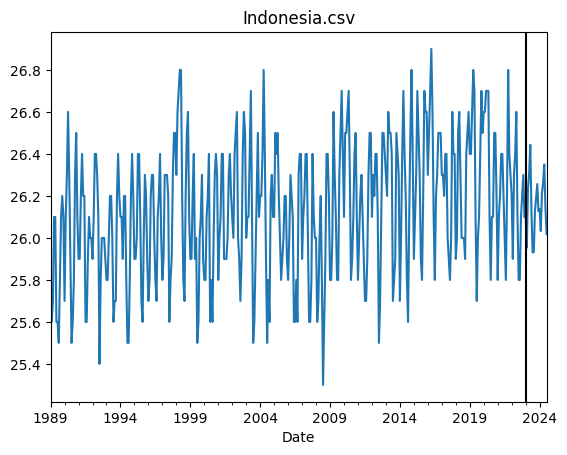

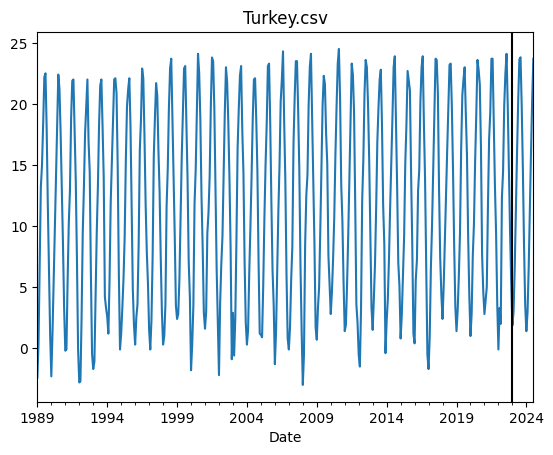

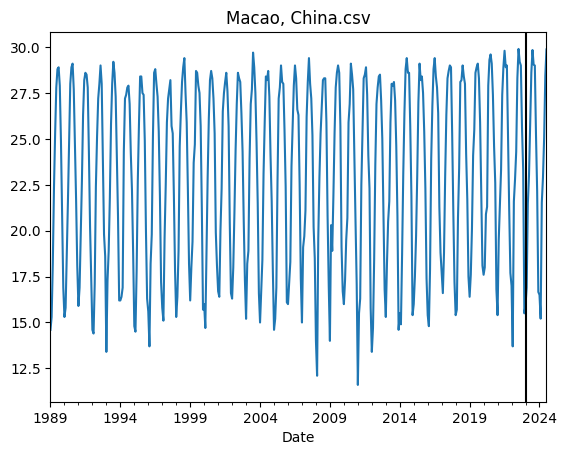

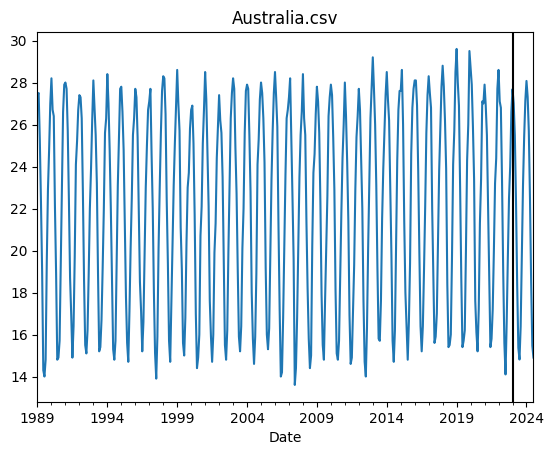

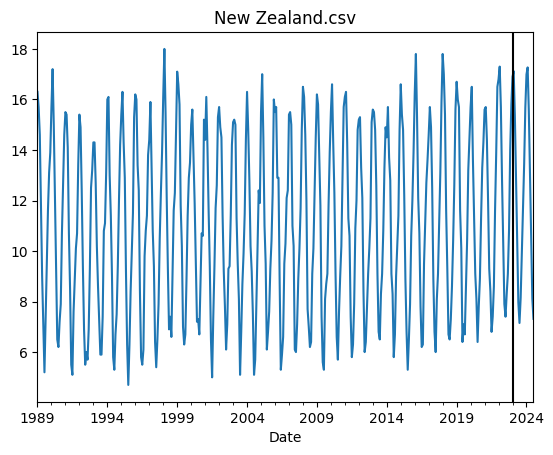

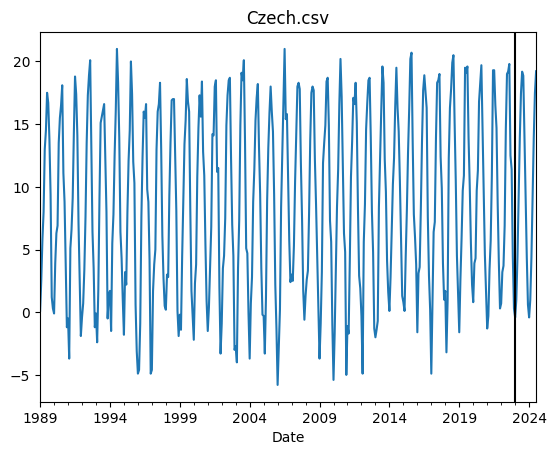

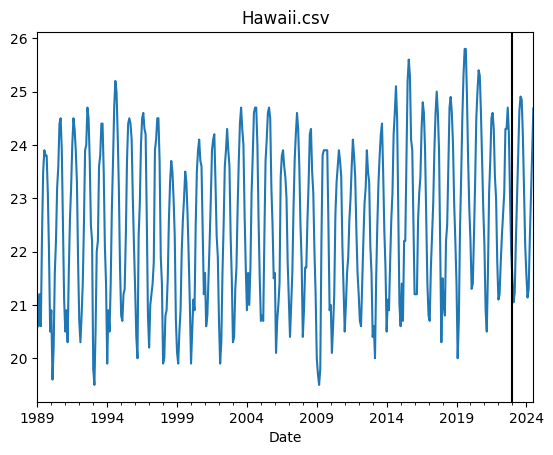

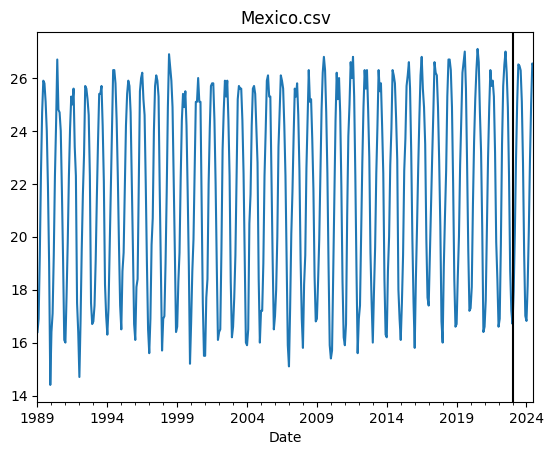

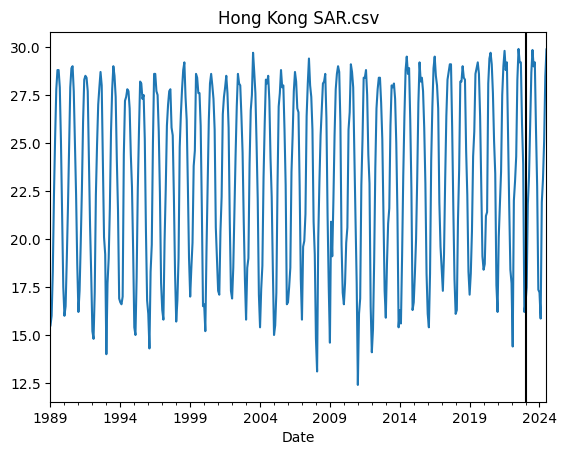

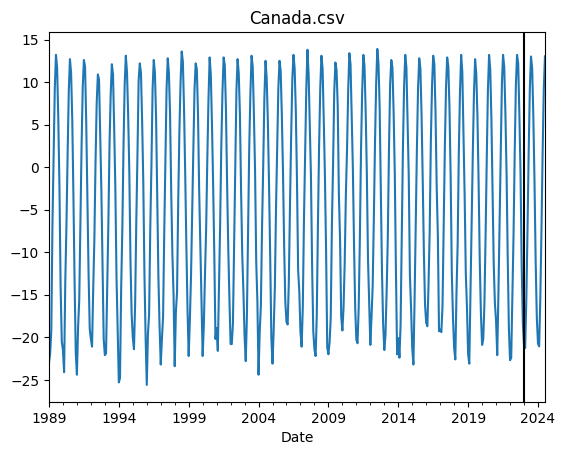

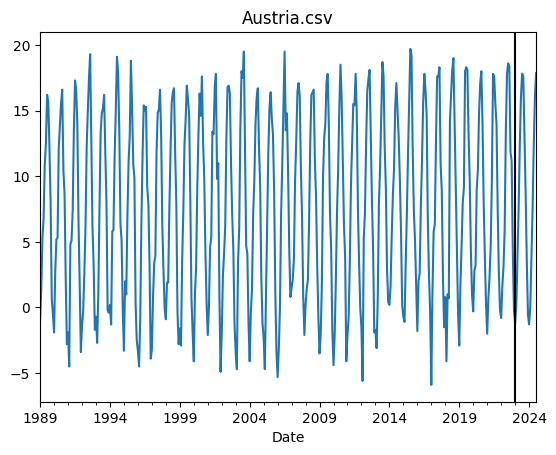

In [27]:
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        country_df = pd.read_csv(os.path.join(imputed_dir, f))
        country_df['Date'] = pd.to_datetime(country_df['Date'])
        country_df = country_df.set_index('Date')
        country_df['Temperature'].plot()
        plt.title(f)
        plt.axvline(datetime(2023, 1, 1), color='black')
        plt.show()

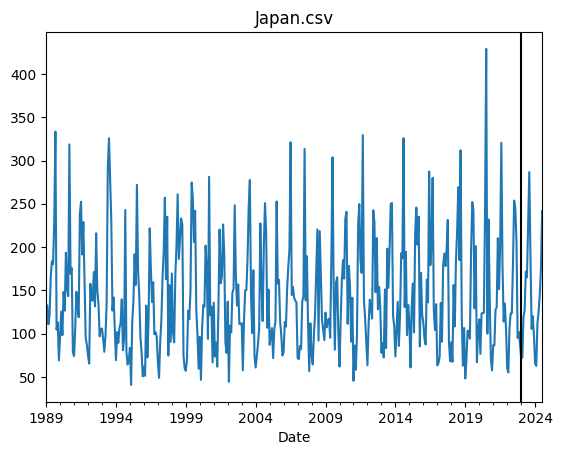

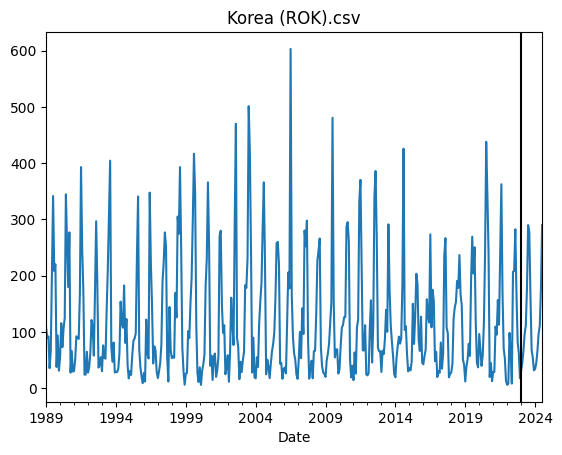

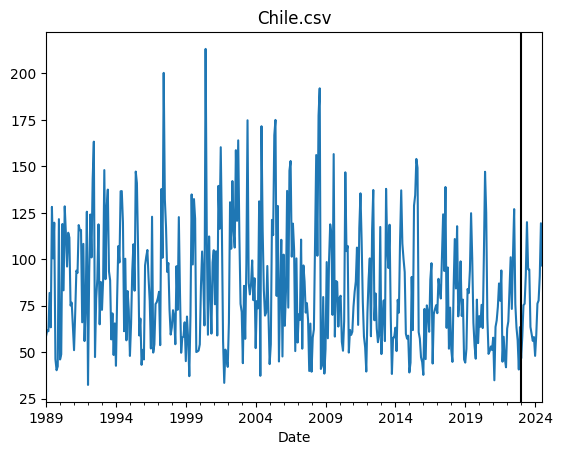

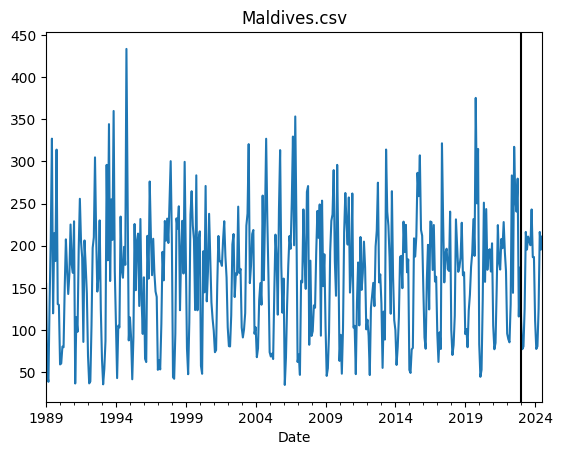

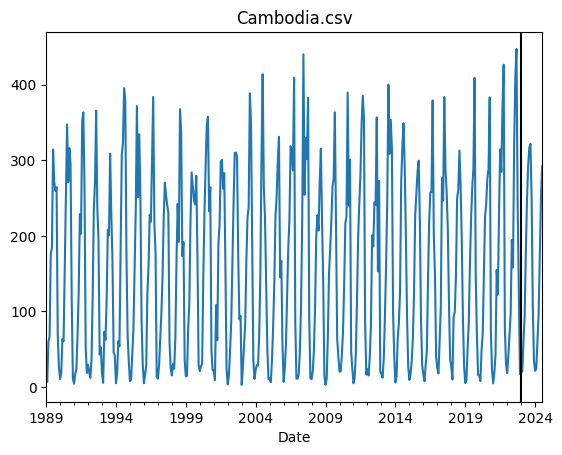

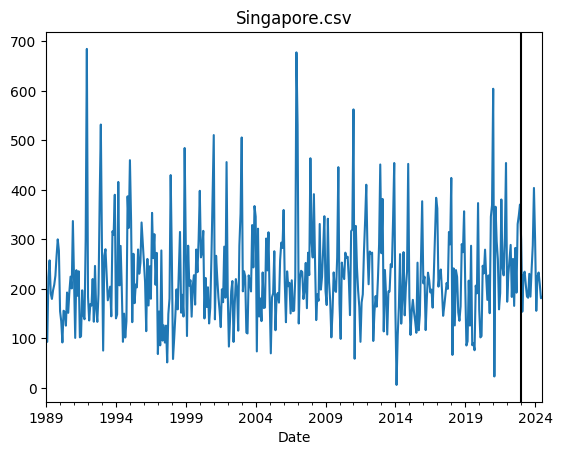

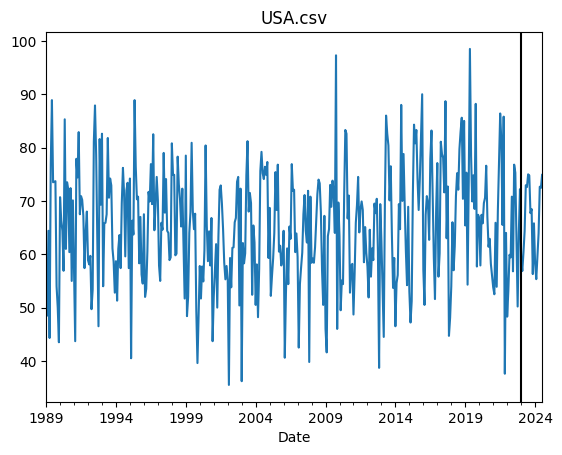

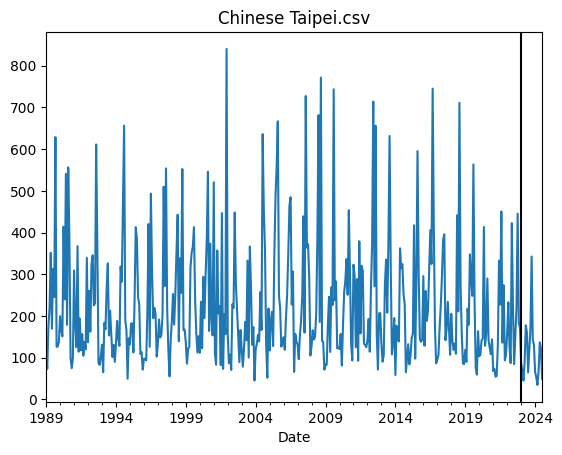

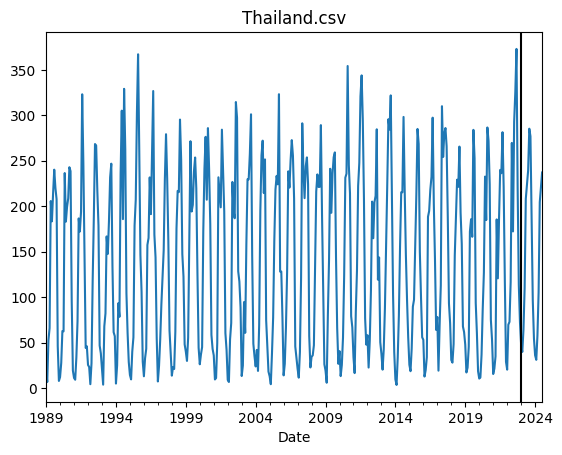

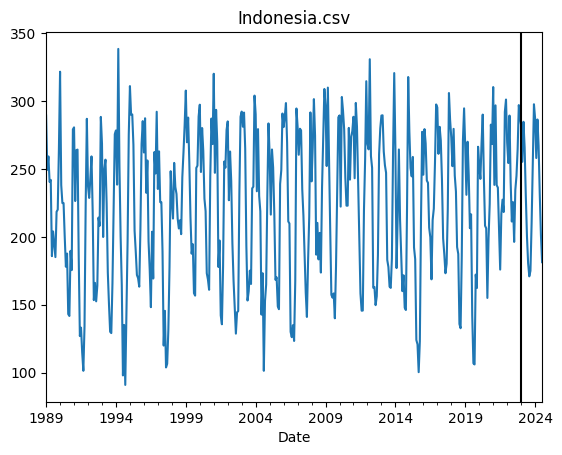

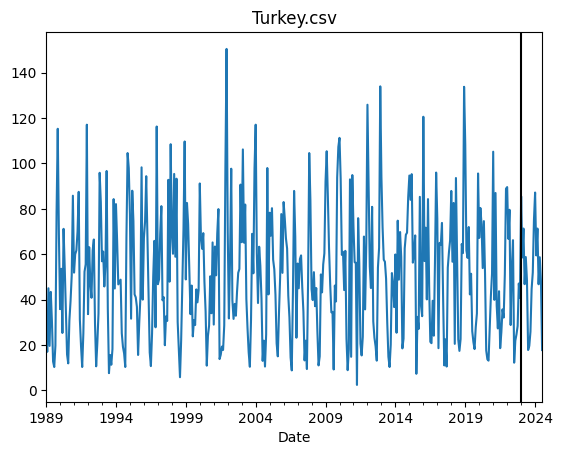

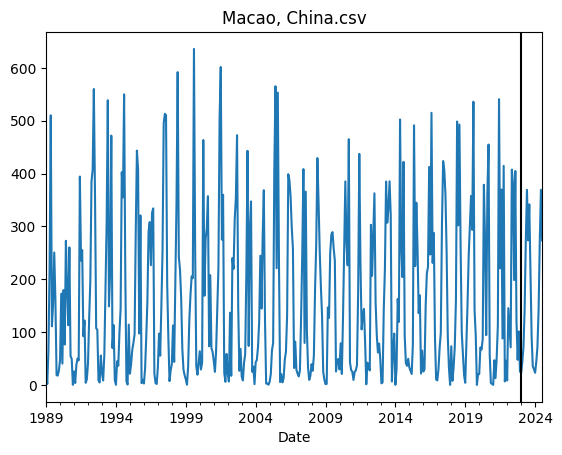

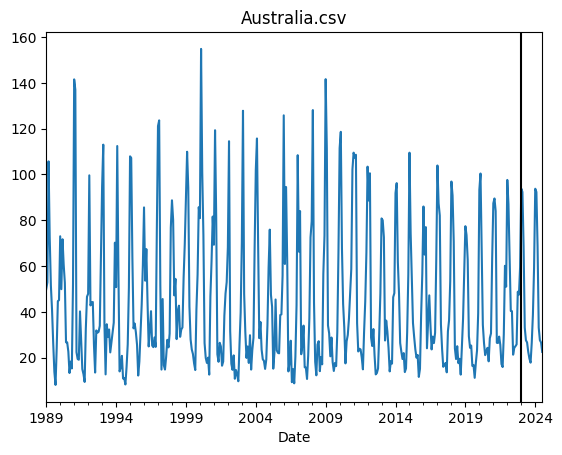

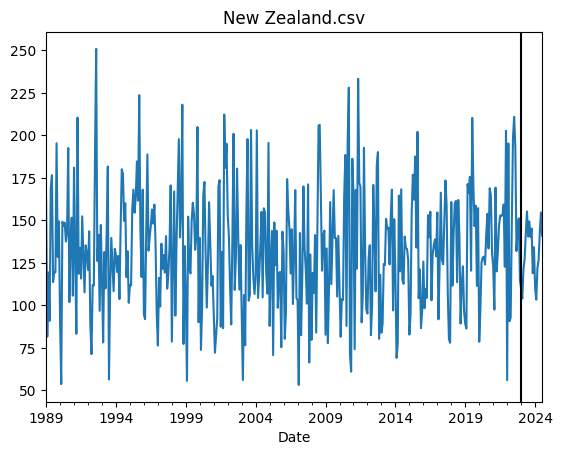

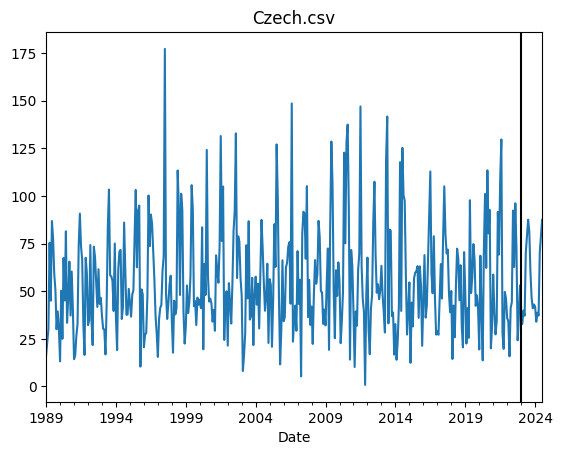

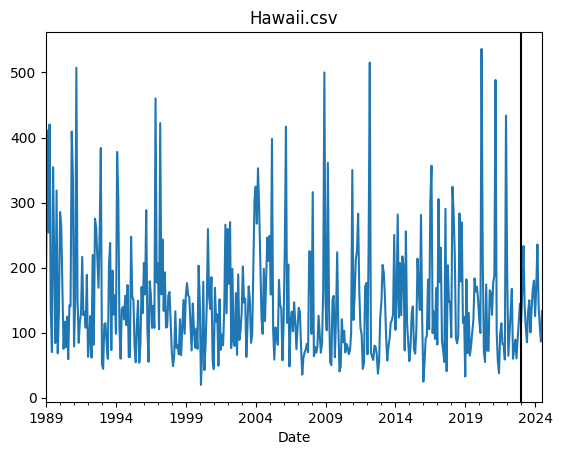

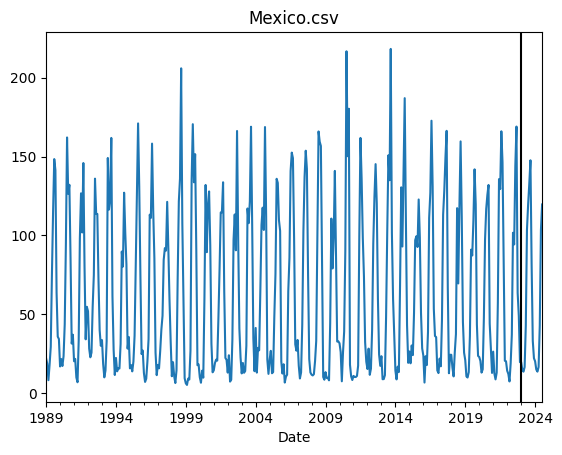

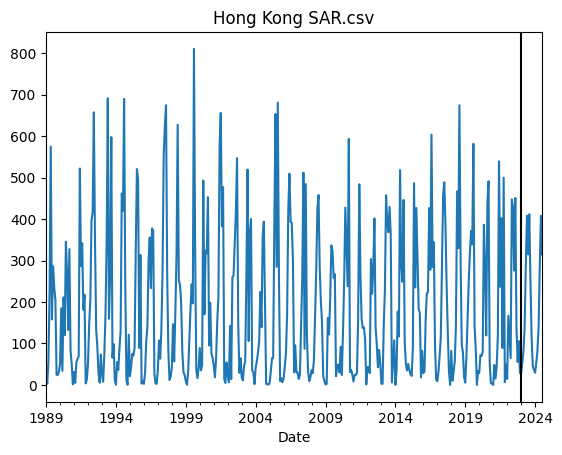

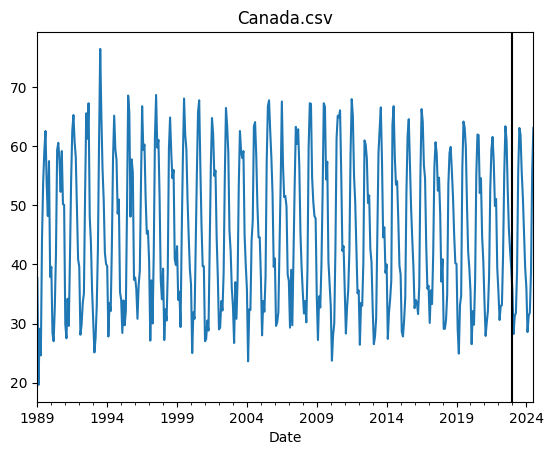

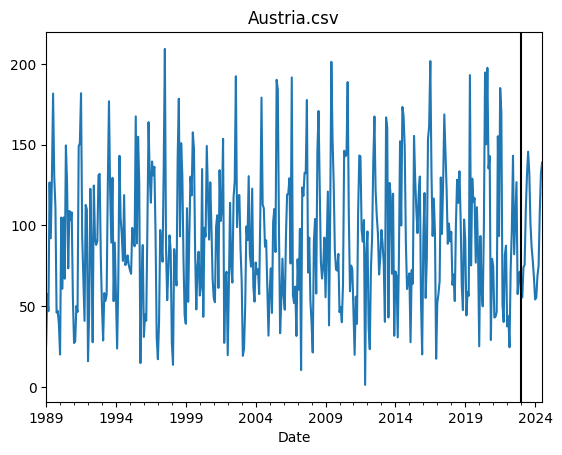

In [28]:
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        country_df = pd.read_csv(os.path.join(imputed_dir, f))
        country_df['Date'] = pd.to_datetime(country_df['Date'])
        country_df = country_df.set_index('Date')
        country_df['Precipitation'].plot()
        plt.title(f)
        plt.axvline(datetime(2023, 1, 1), color='black')
        plt.show()